#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 5 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [ ]:
import sys
!{sys.executable} -m pip install gdown h5py

In [25]:
# run this cell only the first time you run the notebook
run_this_cell = False
if run_this_cell:
    import gdown
    url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
    output = "IT_data.h5"
    gdown.download(url, output, quiet=False, fuzzy=True)

In [26]:
# import useful libraries
from utils import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

### Load the data

In [27]:
path_to_data = '' 
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [28]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


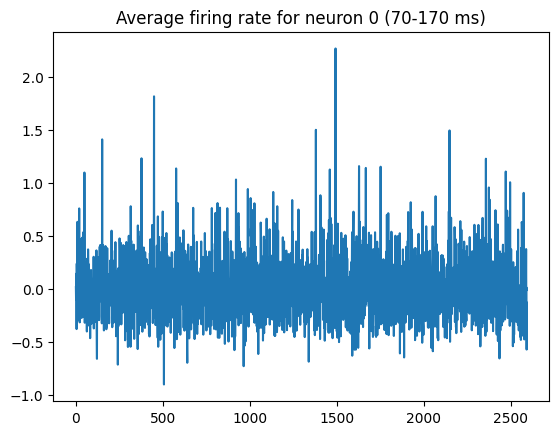

In [29]:
# we can now visualize the neuron response to the different stimuli
neuron_idx = 0

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])
# note that each point represents average respose of the neuron over 100 ms to a different stimulus
# in fact there are 2592 peaks in the plot

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [32]:
from ridgecross import *

In [39]:
# transform objects to 8 classes and to int
objects_train_8 = transform_classes_to_int(transform_to_8_classes(objects_train))
objects_val_8 = transform_classes_to_int(transform_to_8_classes(objects_val))

# Flatten stimulus data
stimulus_train_res = stimulus_train.reshape((2592, -1))
stimulus_val_res = stimulus_val.reshape((288, -1))

# concatenate the 2 arrays
X_train = np.concatenate((stimulus_train_res, np.array(objects_train_8).reshape(-1,1)), axis=1)
X_val = np.concatenate((stimulus_val_res, np.array(objects_val_8).reshape(-1,1)), axis=1)

print('Shape of X_train: ', X_train.shape)
print('Shape of X_val: ', X_val.shape)


Shape of X_train:  (2592, 150529)
Shape of X_val:  (288, 150529)


In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score

# one-hot encode the class labels for the training set
encoder = OneHotEncoder(sparse=False)
class_labels_one_hot = encoder.fit_transform(X_train[:,-1].reshape(-1, 1))

# one-hot encode the class labels for the validation set
class_labels_one_hot_val = encoder.transform(X_val[:,-1].reshape(-1, 1))

# concatenate the one-hot encoded labels to the feature matrix
X_train_augmented = np.hstack((X_train[:,:-1], class_labels_one_hot))
X_val_augmented = np.hstack((X_val[:,:-1], class_labels_one_hot_val))

# fit ridge regression model to augmented data
ridge = Ridge(alpha=10, fit_intercept=True)
ridge.fit(X_train_augmented, spikes_train)

# make predictions using validation set
y_pred = ridge.predict(X_val_augmented)

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

(array([ 3.,  0.,  1.,  3.,  7.,  5., 10., 11.,  8., 15., 21., 18., 18.,
        17., 11.,  5.,  7.,  2.,  5.,  1.]),
 array([-2.16940966, -2.06928693, -1.96916419, -1.86904146, -1.76891873,
        -1.66879599, -1.56867326, -1.46855053, -1.36842779, -1.26830506,
        -1.16818233, -1.06805959, -0.96793686, -0.86781413, -0.76769139,
        -0.66756866, -0.56744593, -0.46732319, -0.36720046, -0.26707773,
        -0.16695499]),
 <BarContainer object of 20 artists>)

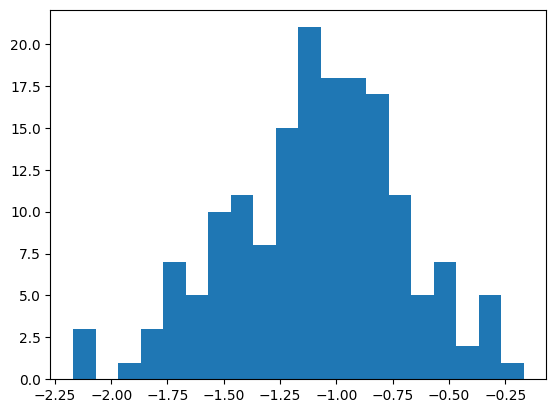

In [35]:
# calculate explained variance score for predictions
evs = explained_variance_score(spikes_val, y_pred)

# compute the explained variance per neuron
ev_per_neuron = 1 - np.var(y_pred - spikes_val, axis=0) / np.var(spikes_val, axis=0)
# print(evs, np.mean(ev_per_neuron)) # they are the same as expected

# print histogram of explained variance per neuron
plt.hist(ev_per_neuron, bins=20)

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [16]:
# perform PCA

n_comp = 1000

pca = PCA(n_components=n_comp)
pca.fit(stimulus_train_res)
pca_filters = pca.components_
pca_features_train = pca.transform(stimulus_train_res)
print(pca_features_train.shape)

# Take 1000 PCs for the validation set as well
pca_features_val = pca.transform(stimulus_val_res)
print(pca_features_val.shape)

# Now join them with the object_8 filters

pca_feature_matrix_8 = np.concatenate((pca_features_train, np.array(objects_train_8).reshape(-1,1)), axis=1)
print(pca_feature_matrix_8.shape)

# same for validation set
pca_feature_matrix_8_val = np.concatenate((pca_features_val, np.array(objects_val_8).reshape(-1,1)), axis=1)
print(pca_feature_matrix_8_val.shape)


(2592, 1000)
(288, 1000)
(2592, 1001)
(288, 1001)


In [17]:
# concatenate the one-hot encoded labels to the feature matrix
pca_feature_matrix_8_augmented = np.hstack((pca_feature_matrix_8[:,:-1], class_labels_one_hot))
pca_feature_matrix_8_val_augmented = np.hstack((pca_feature_matrix_8_val[:,:-1], class_labels_one_hot_val))

Overall explained variance: 0.0396611681693936
Overall correlation: 0.3523626892594672


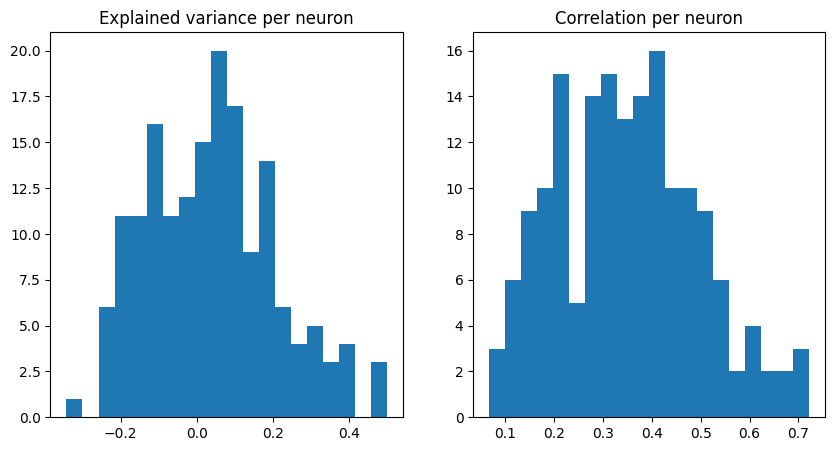

In [18]:
from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score

# fit ridge regression model with arbitrary lambda: 10
num_classes = 8
lamb = 10
ridge = Ridge(alpha=lamb, fit_intercept=True)
ridge.fit(pca_feature_matrix_8_augmented, spikes_train)

# make predictions using validation set
y_pred = ridge.predict(pca_feature_matrix_8_val_augmented)

# compute the explained variance for each neuron
ev_per_neuron = 1 - np.var(y_pred - spikes_val, axis=0) / np.var(spikes_val, axis=0)
# compute overall explained variance
ev = explained_variance_score(spikes_val, y_pred)
print('Overall explained variance:', ev)

# compute the correlation for each neuron
corr_per_neuron = np.array([np.corrcoef(y_pred[:, i], spikes_val[:, i], rowvar=False)[0, 1] for i in range(y_pred.shape[1])])
# compute overall correlation
corr = np.mean(corr_per_neuron)
print('Overall correlation:', corr)

# create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# print histogram of explained variance per neuron
ax = axs[0]
ax.hist(ev_per_neuron, bins=20)
ax.set_title('Explained variance per neuron')

# print histogram of correlation per neuron
ax = axs[1]
ax.hist(corr_per_neuron, bins=20)
ax.set_title('Correlation per neuron')

plt.show()


##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm 

# number of classes
num_classes = 8

# concatenate the one-hot encoded labels to the feature matrix
X_augmented = pca_feature_matrix_8_augmented

# define the splitter object
splitter = StratifiedKFold(n_splits=20)



# initialize lists to store the results
best_lambda_per_neuron = []
best_ev_per_neuron = []

# create candidate lambda values
lambdas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 50, 100]

# loop over different neurons
for neuron in tqdm(range(spikes_train.shape[1])):
    best_ev = -5
    best_lamb = 0

    # loop over different lambda values
    
    for lamb in lambdas:
        evs = []
        # split into training and validation sets
        for (train_index, val_index) in splitter.split(pca_feature_matrix_8[:,:-1], pca_feature_matrix_8[:,-1]):
            # split the data into training and validation sets
            X_train_augmented, X_val_augmented = X_augmented[train_index,:], X_augmented[val_index,:]
            y_train, y_val = spikes_train[train_index, neuron], spikes_train[val_index, neuron]
                
            # fit ridge regression model to X_train after one-hot encoding the class labels
            ridge = Ridge(alpha=lamb, fit_intercept=True)
            ridge.fit(X_train_augmented, y_train)
            
            # make predictions using validation set
            y_pred = ridge.predict(X_val_augmented)
            
            # compute the ev for each neuron on the val set 
            ev_per_neuron = explained_variance_score(y_val, y_pred)
            evs.append(ev_per_neuron)
            #print('Explained variance for neuron {0} and lambda = {1}: {2} '.format(neuron, lamb, ev_per_neuron))
        ev = np.mean(evs)
        if ev > best_ev:
            best_ev = ev
            best_lamb = lamb
    
    best_ev_per_neuron.append(best_ev)
    best_lambda_per_neuron.append(best_lamb)
        
    #print('Explained variance for neuron {0} and lambda = {1}: {2} '.format(neuron, best_lamb, best_ev))

    



In [ ]:
# now use the best lambda for each neuron to fit the model on the entire training set
# and evaluate it on the validation set

num_classes = 8
ev_per_neuron = []
corr_per_neuron = []
for neuron in tqdm(range(spikes_train.shape[1])):
    lamb = best_lambda_per_neuron[neuron]
    ridge = Ridge(alpha=lamb, fit_intercept=True)
    ridge.fit(pca_feature_matrix_8_augmented, spikes_train[:, neuron])

    # make predictions using validation set
    y_pred = ridge.predict(pca_feature_matrix_8_val_augmented)

    # compute explained variance
    ev = explained_variance_score(spikes_val[:,neuron], y_pred)
    ev_per_neuron.append(ev)

    # compute the correlation for each neuron
    corr = np.corrcoef(y_pred, spikes_val[:, neuron], rowvar=False)[0, 1]
    #corr = np.mean(corr)
    corr_per_neuron.append(corr)

# create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# print histogram of explained variance per neuron
ax = axs[0]
ax.hist(ev_per_neuron, bins=20)
ax.set_title('Explained variance per neuron')

# print histogram of correlation per neuron
ax = axs[1]
ax.hist(corr_per_neuron, bins=20)
ax.set_title('Correlation per neuron')

plt.show()

# print the average explained variance and correlation
print('Average explained variance:', np.mean(ev_per_neuron))
print('Average correlation:', np.mean(corr_per_neuron))

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [44]:
import torch
import torch.utils.data as data
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm

weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)
model.eval()

# placeholders for predictions and features
batch_size = 64
layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']
num_components = 1000

data_loader = data.DataLoader(stimulus_train, batch_size=batch_size, shuffle=False)
data_loader_val = data.DataLoader(stimulus_val, batch_size=batch_size, shuffle=False)

pca_dict_train= {}
pca_dict_val = {}

for name in tqdm(layers):
    pca_dict_train[name] = []
    hook = getattr(model, name).register_forward_hook(lambda m, i, o: pca_dict_train[name].append(o.detach().numpy()))

    with torch.no_grad():
        for batch in data_loader:
            x = np.stack(batch).astype(np.float32)
            x = torch.from_numpy(x)
            preds = model(x)

        layer_output = np.concatenate(pca_dict_train[name], axis=0)
    
    hook.remove()
    
    # same for the validation test 
    pca_dict_val[name] = []
    hook_val = getattr(model, name).register_forward_hook(lambda m, i, o: pca_dict_val[name].append(o.detach().numpy()))

    with torch.no_grad():
        for batch in data_loader_val:
            x = np.stack(batch).astype(np.float32)
            x = torch.from_numpy(x)
            preds = model(x)

        layer_output_val = np.concatenate(pca_dict_val[name], axis=0)
    
    hook_val.remove()

    
    # compute pca (fit on train and transform both train an val)
    pca = PCA(n_components=num_components)
    pca.fit(layer_output.reshape(layer_output.shape[0], -1))
    pca_dict_train[name] = pca.transform(layer_output.reshape(layer_output.shape[0], -1))
    pca_dict_val[name] = pca.transform(layer_output_val.reshape(layer_output_val.shape[0], -1))
    

100%|██████████| 6/6 [16:38<00:00, 166.41s/it]


In [46]:
for layer in layers:
    print(pca_dict_train[layer].shape, pca_dict_val[layer].shape)

(2592, 1000) (288, 1000)
(2592, 1000) (288, 1000)
(2592, 1000) (288, 1000)
(2592, 1000) (288, 1000)
(2592, 1000) (288, 1000)
(2592, 1000) (288, 1000)


In [49]:
# feed these results to ridge regression 
from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score, r2_score

# Prepare data
X_train = np.concatenate([pca_dict_train[name] for name in layers], axis=1)
X_val = np.concatenate([pca_dict_val[name] for name in layers], axis=1)
y_train = spikes_train
y_val = spikes_val

# Fit Ridge Regression model
ridge = Ridge(alpha=20, fit_intercept=True)
ridge.fit(X_train, y_train)

# Predict on validation set
y_val_pred = ridge.predict(X_val)

# Compute explained variance and correlation on validation set
ev = explained_variance_score(y_val, y_val_pred)
corr = np.corrcoef(y_val, y_val_pred, rowvar=False)[0,1]
print('Validation set explained variance:', ev)
print('Validation set correlation:', corr)


Validation set explained variance: -0.17017268744252978
Validation set correlation: 0.4345145506198172


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.06235e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Explained variance per layer: [-0.033230126613662356, 0.256112219677085, 0.33301716226907, 0.40891810648498084, 0.3540163646851267, 0.2391827872821263]
Correlation per layer: [0.4345145506198172, 0.4345145506198172, 0.4345145506198172, 0.4345145506198172, 0.4345145506198172, 0.4345145506198172]


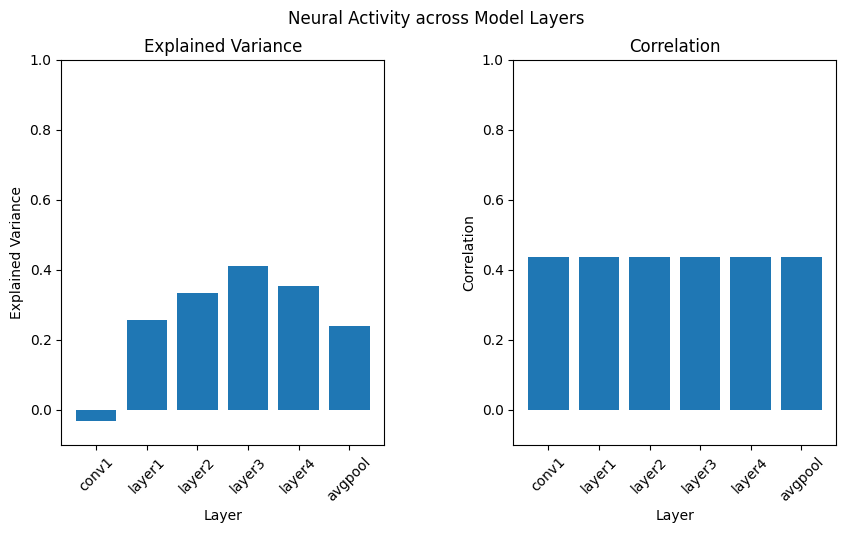

In [64]:
# Plot the distribution of explained variance with respect to the layer of the network 
# (order them based on the depth). How does the neural activity changes across the model layers, 
# can you make some statements about it?
import matplotlib.pyplot as plt
import numpy as np

evs = []
corrs = []

for name in layers:
    X_train = pca_dict_train[name]
    X_val = pca_dict_val[name]
    y_train = spikes_train
    y_val = spikes_val
        
    ridge = Ridge(alpha=20, fit_intercept=True)
    ridge.fit(X_train, y_train)
    y_val_pred = ridge.predict(X_val)
    ev = explained_variance_score(y_val, y_val_pred)
    corr = np.corrcoef(y_val, y_val_pred, rowvar=False)[0,1]
    
    evs.append(ev)
    corrs.append(corr)

print('Explained variance per layer:', evs)
print('Correlation per layer:', corrs)
    
# Plot explained variance
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(layers, evs)
axs[0].set_title('Explained Variance')
axs[0].set_ylim(-0.1, 1)

# Plot correlation
axs[1].bar(layers, corrs)
axs[1].set_title('Correlation')
axs[1].set_ylim(-0.1, 1)


# Set x axis label and tick rotation
for ax in axs:
    ax.set_xlabel('Layer')
    ax.tick_params(axis='x', rotation=45)
    
# Set y axis label
axs[0].set_ylabel('Explained Variance')
axs[1].set_ylabel('Correlation')

# Set plot title and adjust subplot spacing
fig.suptitle('Neural Activity across Model Layers')
fig.subplots_adjust(wspace=0.4)

plt.show()
     

In [65]:
# with randomly initialized weights:
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision.models import resnet50
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm

# Define the model with randomly initialized weights
model = resnet50(weights=None)

# placeholders for predictions and features
batch_size = 64
layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']
num_components = 1000

data_loader = data.DataLoader(stimulus_train, batch_size=batch_size, shuffle=False)
data_loader_val = data.DataLoader(stimulus_val, batch_size=batch_size, shuffle=False)

pca_dict_train_rndw= {}
pca_dict_val_rndw = {}

for name in tqdm(layers):
    pca_dict_train_rndw[name] = []
    hook = getattr(model, name).register_forward_hook(lambda m, i, o: pca_dict_train_rndw[name].append(o.detach().numpy()))

    with torch.no_grad():
        for batch in data_loader:
            x = np.stack(batch).astype(np.float32)
            x = torch.from_numpy(x)
            preds = model(x)

        layer_output = np.concatenate(pca_dict_train_rndw[name], axis=0)
    
    hook.remove()
    
    # same for the validation test 
    pca_dict_val_rndw[name] = []
    hook_val = getattr(model, name).register_forward_hook(lambda m, i, o: pca_dict_val_rndw[name].append(o.detach().numpy()))

    with torch.no_grad():
        for batch in data_loader_val:
            x = np.stack(batch).astype(np.float32)
            x = torch.from_numpy(x)
            preds = model(x)

        layer_output_val = np.concatenate(pca_dict_val_rndw[name], axis=0)
    
    hook_val.remove()

    
    # compute pca (fit on train and transform both train an val)
    pca = PCA(n_components=num_components)
    pca.fit(layer_output.reshape(layer_output.shape[0], -1))
    pca_dict_train_rndw[name] = pca.transform(layer_output.reshape(layer_output.shape[0], -1))
    pca_dict_val_rndw[name] = pca.transform(layer_output_val.reshape(layer_output_val.shape[0], -1))


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 6/6 [18:02<00:00, 180.38s/it]


In [71]:
# compare the prediction obtained for layer 3 in both cases (imagenetik weights and random weights)

name = 'layer3'

X_train = pca_dict_train[name]
X_train_rndw = pca_dict_train_rndw[name]

X_val = pca_dict_val[name]
X_val_rndw = pca_dict_val_rndw[name]

y_train = spikes_train
y_val = spikes_val



ridge = Ridge(alpha=20, fit_intercept=True)
ridge.fit(X_train, y_train)
y_val_pred = ridge.predict(X_val)
ev = explained_variance_score(y_val, y_val_pred)
corr = np.corrcoef(y_val, y_val_pred, rowvar=False)[0,1]

ridge_rndw = Ridge(alpha=20, fit_intercept=True)
ridge_rndw.fit(X_train_rndw, y_train)
y_val_pred_rndw = ridge.predict(X_val_rndw)
ev_rndw = explained_variance_score(y_val, y_val_pred_rndw)
corr_rndw = np.corrcoef(y_val, y_val_pred_rndw, rowvar=False)[0,1]


print('Explained variance for imagenetik weights is:', ev)
print('Explained variance for rnd weights is:', ev_rndw)

print('Correlation for imagenetik weights is:', corr)
print('Correlation for rnd weights is:', corr_rndw)

# hence the imagenetik is performing far better.comment on this 
# Still have to understand why the correlation is always a constant....
 


Explained variance for imagenetik weights is: 0.40891810648498084
Explained variance for rnd weights is: -1.6381566602559317
Correlation for imagenetik weights is: 0.4345145506198172
Correlation for rnd weights is: 0.4345145506198172
